In [1]:
from IPython.display import Image

import lzma, json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
import pickle
import string

%config InlineBackend.figure_format = 'retina'
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import ngrams, FreqDist
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/70960524/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/70960524/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/70960524/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/70960524/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Project C EDA 

The three questions we kept in mind while doing EDA were:

1) Given everything you have learned, if you faced this data set in the wild, how would you proceed? 

2) What are the important measures? 

3) What are the right questions to ask, and how can the data answer them?

Before beginning EDA, we decided to first read up on the current uses of the data, and why Harvard decided to publish it. Currently, the data is used to examine how the usage of words/topics changes over time (e.g. "abortion", "bear arms", etc.). It seems that the questions we'd like to investigate through this EDA are:

What are the important characteristics of these cases? What are they about? How do they differ between states? How do they change over time?

We may not be able to answer all of these questions through our EDA, but it is good to keep them in mind. It seems like the most important aspect of our data will be the case body, as measures such as pages, docket number, volume, etc. probably don't matter too much for our purposes. We explored the data using both NLP and non-NLP methods. For the NLP, we only included our work for a single state, New Mexico, because our code is quite repetitive and we felt a single state was representative. In addition, we faced computational difficulties with some of the other states (Illinois was too large and crashed Jupyterhub).

# Importing the Data

In order to parse our data into a useful form, we read the file and then convert the data into nested dictionaries.

In [2]:
# reading the data into a list
cases = []
with lzma.open("New Mexico-20200302-text/data/data.jsonl.xz") as in_file:
    for line in in_file:
        case = json.loads(str(line, 'utf8'))
        cases.append(case)

In [3]:
# parse list into dictionary 
case_data = {}
for k,v in [(key,d[key]) for d in cases for key in d]:
    if k not in case_data: case_data[k]=[v]
    else: case_data[k].append(v)

In [4]:
# get casebody, ignore attributes like volume, url, id, etc.
casebody = case_data['casebody']
case_text = {}
for k,v in [(key,d[key]) for d in casebody for key in d]:
    if k not in case_text: case_text[k]=[v]
    else: case_text[k].append(v)

In [5]:
# get data from casebody, ignore attributes like judges
casetemp = case_text['data']
case_pre = {}
for k,v in [(key,d[key]) for d in casetemp for key in d]:
    if k not in case_pre: case_pre[k]=[v]
    else: case_pre[k].append(v)

In [6]:
# get actual case text 
case_almost = case_pre['opinions']
text_final = {}
for i in range(len(case_almost)):
    for k,v in [(key,d[key]) for d in case_almost[i] for key in d]:
        if k not in text_final: text_final[k]=[v]
        else: text_final[k].append(v)

In [7]:
case_texts = text_final['text']

In [8]:
len(case_texts)

21061

This is the number of cases in the New Mexico dataset, which is the smallest, with 21,061. We now have case_texts, which is a list of case brief strings.

# Cleaning the Data for NLP

First, we'd like to clean and prepare the data for NLP analysis, which requires us to separate our sentences into individual words. We use NLTK's stopwords corpus to strip out uninformative words like "the", "a", etc.

In [9]:
def clean_words(fname):
    text = fname
    text = text.rstrip()
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words_clean = [w for w in words if not w in stop_words]
    return words_clean

In [10]:
the_clean_text = []
for i in range(len(case_texts)):
    the_clean_text.append(clean_words(fname = case_texts[i]))
the_clean_texts= np.array(the_clean_text)

We now have a list of lists of words, where the_clean_text[0] is the list of words for the first case.

# Visualizing Word Frequency
Now, out first step is look at the distribution of words used in the briefs.

In [11]:
#get most common words from clean texts
most_common_words = []
fdist = []

for i in range(len(the_clean_text)):
    fdist1 = FreqDist(the_clean_text[i])
    most_common = fdist1.most_common(20)
    fdist.append(fdist1)
    most_common_words.append(most_common)

In [12]:
filter_s = []

for most_common_words[0] in most_common_words:
    for w in most_common_words[0]: 
        filter_s.append(w) 
        
def Sort_Tuple(tup):
    d = {x:0 for x, _ in tup} 
    for name, num in tup: d[name] += num 
  
    Output = list(map(tuple, d.items())) 
    return(sorted(Output, key = lambda Output: Output[1],reverse = True))
  
sorted_words=Sort_Tuple(filter_s)
sorted_words[:20]

[('The', 317270),
 ('v.', 238052),
 ('court', 196248),
 ('N.M.', 143341),
 ('P.2d', 125471),
 ('trial', 91731),
 ('State', 88841),
 ('evidence', 69481),
 ('Defendant', 69380),
 ('*', 68454),
 ('defendant', 60265),
 ('district', 56660),
 ('upon', 45772),
 ('In', 43410),
 ('would', 41032),
 ('Section', 40953),
 ('jury', 35461),
 ('said', 34996),
 ('We', 34558),
 ('case', 31329)]

Text(0.5, 1.0, 'Frequency of Top 50 Words in New Mexico Case Law Briefs')

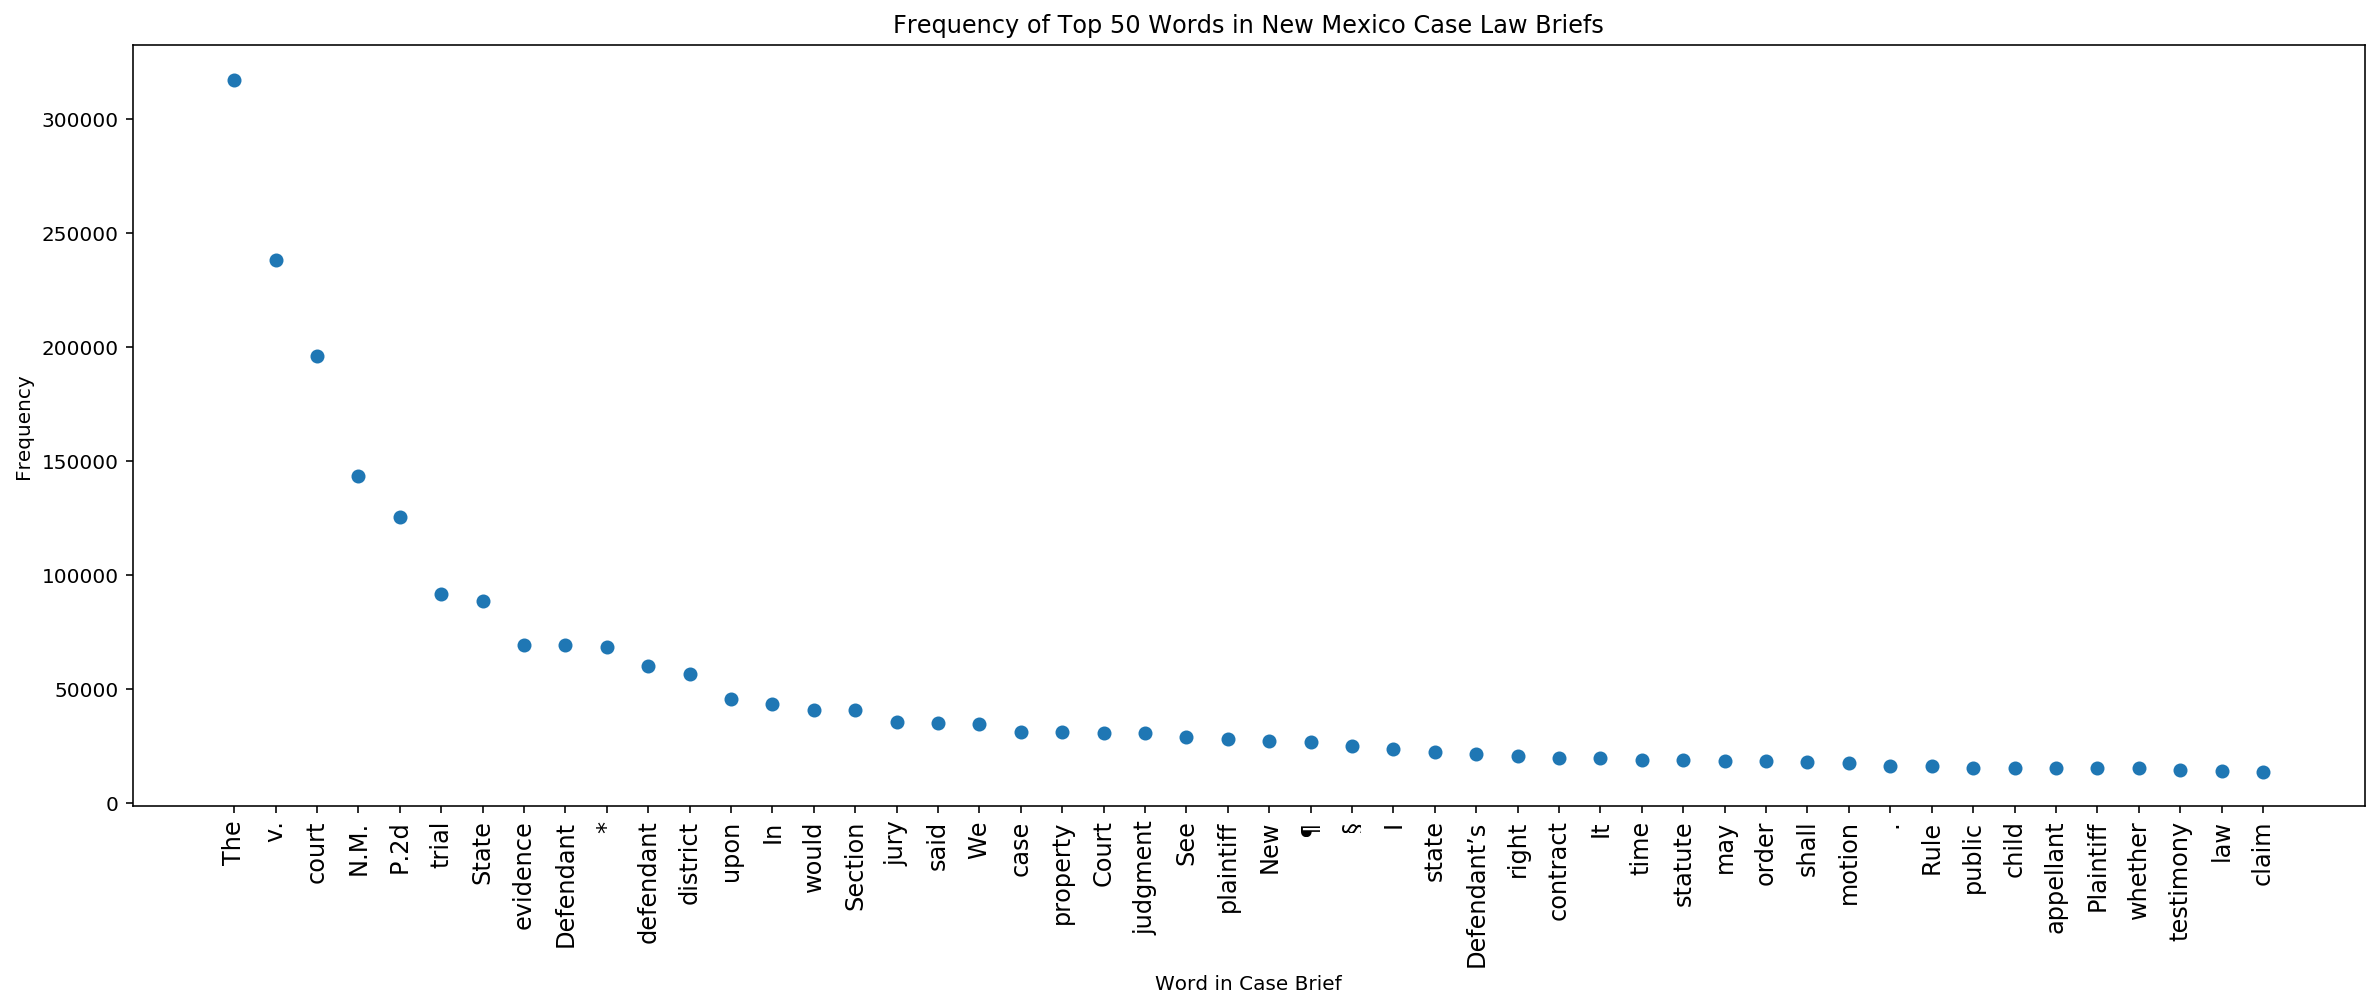

In [16]:
testList2 = [(elem1, elem2) for elem1, elem2 in sorted_words]
plt.figure(figsize=(20,7))
plt.xticks(rotation=90,fontsize=12)
plt.scatter(*zip(*testList2[:50]))
plt.xlabel('Word in Case Brief')
plt.ylabel('Frequency')
plt.title('Frequency of Top 50 Words in New Mexico Case Law Briefs')

We can see that we probably still want to do additional cleaning of the data, to remove symbols and other extraneous words. Since this frequency plot is not terribly informative, we tried a few other ways of visualizing the frequency of words in the data. 

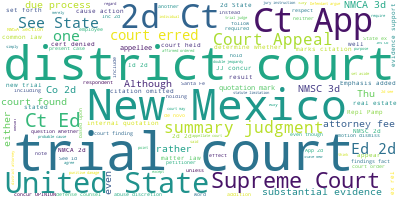

In [27]:
from wordcloud import WordCloud
total_string = ','.join([','.join(i) for i in the_clean_text])
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(total_string)
wordcloud.to_image()

Using a word cloud to visulaize the words used not only is more intuitive to understand, but the wordcloud package also removes symbols/extraneous words and puts together bi-grams (e.g. "New Mexico", "trial court"), which is helpful. However, simply analyzing the frequency of words still doesn't provide much insight into the content of the cases, so we decided to try some topic modelling to see what the topics are actually about. 

# Topic Modelling 
We arbitrarily chose 10 topics to group by at first--ideally, we would try grouping by several different numbers of topics, but due to computational limits, we could only run it once for each state. For this section, we used NLTK's wordnet to find the meaning of words, Gensim to perform LDA, and pyLDAvis to visualize our topics

https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

First, we have to clean the data further by lemmatizing--i.e. turning all forms of a word with the same meaning into the root word. 

In [52]:
import spacy
from spacy.lang.en import English
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [31]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [53]:
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/70960524/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [55]:
text_data = []
for case in case_texts:
    tokens = prepare_text_for_lda(case)
    text_data.append(tokens)

In [56]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)

In [57]:
corpus = [dictionary.doc2bow(text) for text in text_data]

In [58]:
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [60]:
import gensim
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model10.gensim')

Now that we've created our model, we can take a look at how our LDA model decided to group our topics. We print the top four most relevant words for each topic group. 

In [61]:
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.052*"defendant" + 0.029*"state" + 0.018*"evidence" + 0.017*"court"')
(1, '0.024*"property" + 0.014*"interest" + 0.013*"court" + 0.012*"estate"')
(2, '0.067*"court" + 0.026*"district" + 0.021*"appeal" + 0.020*"order"')
(3, '0.031*"defendant" + 0.030*"officer" + 0.020*"state" + 0.013*"search"')
(4, '0.016*"property" + 0.015*"water" + 0.013*"state" + 0.010*"right"')
(5, '0.021*"plaintiff" + 0.021*"appellant" + 0.020*"court" + 0.019*"defendant"')
(6, '0.031*"state" + 0.022*"section" + 0.020*"statute" + 0.013*"court"')
(7, '0.023*"plaintiff" + 0.016*"claim" + 0.015*"court" + 0.010*"policy"')
(8, '0.058*"child" + 0.021*"court" + 0.014*"father" + 0.012*"mother"')
(9, '0.022*"injury" + 0.021*"worker" + 0.017*"compensation" + 0.017*"employer"')


We can see that the topics actually do appear to be distinct. These topics can be contrasted with topics from other states, such as North Carolina and Arkansas, respectively.

<img src="NC_topics.png" alt="Drawing" style="width: 500px;"/>
<img src="AK_topics.png" alt="Drawing" style="width: 500px;"/>

For example, New Mexico is the only state that has worker's compensation as a significant portion of the cases, which makes sense because New Mexico is a more agricultural area than Arkansas or North Carolina. Arkansas has more cases related to estates, inheritance, and insurance, while North Carolina's topics are somewhat less distinct. 

In [62]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model10.gensim')

Finally, we use pyLDAvis to do a more comprehensive visualization of our topics.

In [64]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/share/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


This allows us to visualize how large the topics are, how much they overlap, and examine the distributions of a single word among all the topics. 

# Non-NLP Exploratory Analysis
Since one of the questions we're interested in answering is how the states differ, we examine some of the non-language-related attributes of the data for the different states. In order to do this, we combine data from all the datasets into a single pandas dataframe, adding a state attribute to differentiate between our states.

In [2]:
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [3]:
cases_ar = []
with lzma.open("Arkansas-20200302-text/data/data.jsonl.xz") as in_file:
    for line in in_file:
        case = json.loads(str(line, 'utf8'))
        cases_ar.append(case)
cases_ill = []
with lzma.open("Illinois-20200302-text/data/data.jsonl.xz") as in_file:
    for line in in_file:
        case = json.loads(str(line, 'utf8'))
        cases_ill.append(case)        
cases_nc = []
with lzma.open("North Carolina-20200302-text/data/data.jsonl.xz") as in_file:
    for line in in_file:
        case = json.loads(str(line, 'utf8'))
        cases_nc.append(case)
cases_nm = []
with lzma.open("New Mexico-20200302-text/data/data.jsonl.xz") as in_file:
    for line in in_file:
        case = json.loads(str(line, 'utf8'))
        cases_nm.append(case)
arkansas = pd.DataFrame(cases_ar)
illinois = pd.DataFrame(cases_ill)
new_mexico = pd.DataFrame(cases_nm)
n_carolina = pd.DataFrame(cases_nc)

#create dataset with all of the states, adding 'state' as a column
arkansas['state'] = 'Arkansas'
illinois['state'] = 'Illinois'
new_mexico['state'] = 'New Mexico'
n_carolina['state'] = 'North Carolina'

total_list = [arkansas, illinois, new_mexico, n_carolina]

case_df = pd.concat(total_list)
case_df.head()

,id,url,name,name_abbreviation,decision_date,docket_number,first_page,last_page,citations,volume,reporter,court,jurisdiction,frontend_url,preview,casebody,state
0,11640036,https://api.capapi.org/v1/cases/11640036/,FISHER v. REIDER,Fisher v. Reider,1829-11,"Case No. 4,822a",137,138,"[{'type': 'official', 'cite': '9 F. Cas. 137'}]",{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/9...,{'url': 'https://api.capapi.org/v1/courts/ark-...,"{'name': 'Ark.', 'name_long': 'Arkansas', 'whi...",https://cite.capapi.org/f-cas/9/137/,[],"{'data': {'judges': ['Before JOHNSON, ESKRIDGE...",Arkansas
1,11638634,https://api.capapi.org/v1/cases/11638634/,FIKES v. BENTLEY,Fikes v. Bentley,1828-05,"Case No. 4,785a",50,50,"[{'type': 'official', 'cite': '9 F. Cas. 50'}]",{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/9...,{'url': 'https://api.capapi.org/v1/courts/ark-...,"{'name': 'Ark.', 'name_long': 'Arkansas', 'whi...",https://cite.capapi.org/f-cas/9/50/11638634/,[],"{'data': {'judges': ['Before ESKRIDGE, JOHNSON...",Arkansas
2,11641817,https://api.capapi.org/v1/cases/11641817/,FLETCHER v. ELLIS,Fletcher v. Ellis,1836-02,"Case No. 4,863a",266,266,"[{'type': 'official', 'cite': '9 F. Cas. 266'}]",{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/9...,{'url': 'https://api.capapi.org/v1/courts/ark-...,"{'name': 'Ark.', 'name_long': 'Arkansas', 'whi...",https://cite.capapi.org/f-cas/9/266/11641817/,[],"{'data': {'judges': ['Before CROSS and TELL, J...",Arkansas
3,243503,https://api.capapi.org/v1/cases/243503/,Michael NORRIS v. STATE of Arkansas,Norris v. State,1999-07-15,CR 98-1429,397,409-B,"[{'type': 'official', 'cite': '338 Ark. 397'},...",{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/3...,{'url': 'https://api.capapi.org/v1/courts/ark/...,"{'name': 'Ark.', 'name_long': 'Arkansas', 'whi...",https://cite.capapi.org/ark/338/397/,[],"{'data': {'judges': [], 'attorneys': ['Doug No...",Arkansas
4,243557,https://api.capapi.org/v1/cases/243557/,Roger Allen HAMMON v. STATE of Arkansas,Hammon v. State,1999-10-07,CR 98-525,733,739,"[{'type': 'official', 'cite': '338 Ark. 733'},...",{'url': 'https://api.capapi.org/v1/volumes/320...,{'url': 'https://api.capapi.org/v1/reporters/3...,{'url': 'https://api.capapi.org/v1/courts/ark/...,"{'name': 'Ark.', 'name_long': 'Arkansas', 'whi...",https://cite.capapi.org/ark/338/733/,[],"{'data': {'judges': [], 'attorneys': ['Phyllis...",Arkansas


# Distributions of Characteristics in Dataset for All States
To investigate deeper into our entire dataset, we can look at the distribution of various aspects of our data. This may be useful because it could provide insight into how cases have changed over time, how cases in different states differ, and what variables provide insight into the types of cases seen in each state. We can first begin with citations.

## Citations

In [9]:
# look into types of citations present in the citation column
case_df['citation_type'] = [x[0]['type'] for x in case_df['citations']]
case_df['citation_type'].unique()

array(['official', 'nominative'], dtype=object)

We can see that there are 2 unique types of citations: official and nominative. We wanted to see how often each citation type occurred to see if the difference in citation types is relevant.

In [25]:
case_df.groupby('citation_type').count()['id'].sort_values(ascending=False).iplot(kind='bar',
                                            yTitle='Count', linecolor='black', opacity=0.8,
                                            title='Bar chart of Citation Type for all States', xTitle='Citation Type')
plt.savefig('citations.png')

<Figure size 432x288 with 0 Axes>

We can see that official citations are much more common than nominative citations. If we look at the years that the nominative citation type occurs, it tends to be from very old case briefs. We can look at the decision years when the citation was nominative to prove this.

In [10]:
case_df['decision_year'] = case_df['decision_date'].astype(str).str[0:4]
np.sort(case_df['decision_year'][case_df['citation_type']=='nominative'].unique())

array(['1778', '1779', '1780', '1784', '1787', '1789', '1790', '1791',
       '1792', '1793', '1794', '1795', '1796', '1797', '1798', '1799',
       '1800', '1801', '1802', '1803', '1804', '1805', '1806', '1807',
       '1808', '1809', '1810', '1811', '1812', '1813', '1814', '1815',
       '1816', '1817', '1818', '1819', '1820', '1821', '1822', '1823',
       '1824', '1825', '1826', '1827', '1828', '1829', '1830', '1831',
       '1832', '1833', '1834', '1835', '1836', '1837', '1838', '1839',
       '1840', '1841', '1842', '1843', '1844', '1845', '1846', '1847',
       '1848', '1849', '1850', '1851', '1852', '1853', '1854', '1855',
       '1856', '1857', '1858', '1859', '1860', '1861', '1862', '1863',
       '1864', '1866', '1867', '1868'], dtype=object)

As we can see, nominative citations were used from 1778 to 1868.

## Distribution of Courts
Now we can look into how the the distribution of court names is amongst the various states. This would include courts like the Supreme Court of Illinois, Superior Court of Illinois, etc. 

In [28]:
# add a column to the dataset with the type of court that the case took place in
case_df['court_name'] = case_df['court'].apply(lambda x: x['name_abbreviation'])

In [29]:
# make plot for the distribution of courts for all states
case_df.groupby('court_name').count()['id'].sort_values(ascending=False).iplot(kind='bar',
                                            yTitle='Count', linecolor='black', opacity=0.8,
                                            title='Bar chart of Courts for all States', xTitle='Court Name')
plt.savefig('courts.png')

<Figure size 432x288 with 0 Axes>

As we can see, Illinois Appellate Court had the most cases, followed by North Carolina, Arkansas, Illinois, and North Carolina Circuit Appellate Court. This is not terribly informative because Illinois is that largest state with the most cases, so it makes sense that one of its courts has the most cases. It also appears that the district courts tend to have a low number of cases, indicating that either the cases didn't go to court and settled outside of court or there just aren't as many cases.

## Distribution of Types of Cases
Now we wanted to investigate how often certain kinds of cases occur. In our case, we thought it would be interesting to see how many cases are against the state versus other entities since this could perhaps provide insight into potential satisfaction with the state.

In [5]:
case_df['case_vs_state'] = 1*(case_df.name_abbreviation.str.contains("State") | case_df.name_abbreviation.str.contains("state")) 

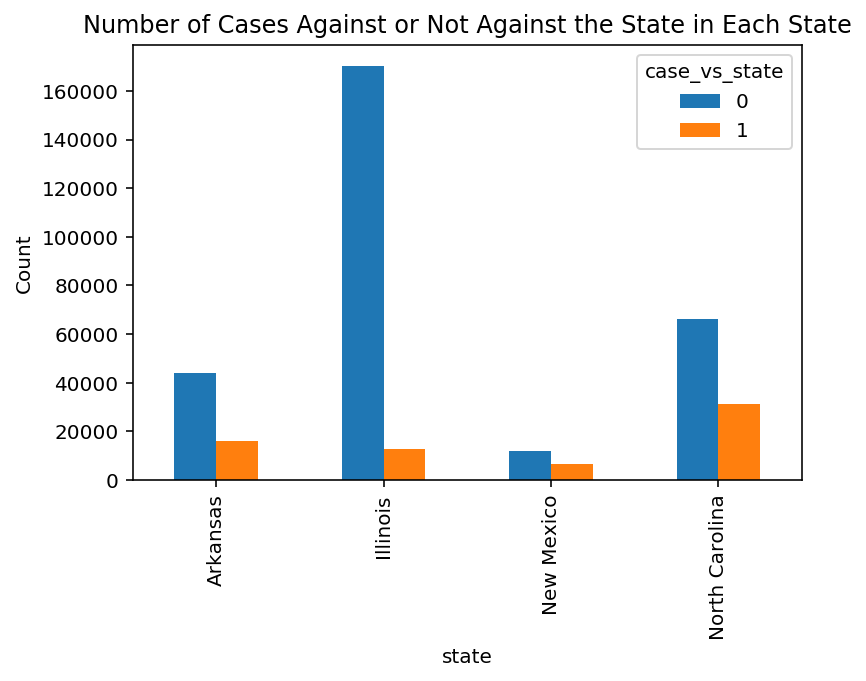

<Figure size 432x288 with 0 Axes>

In [6]:
df=case_df.groupby(['state','case_vs_state']).size()
df=df.unstack()
df.plot(kind='bar')
plt.ylabel('Count')
plt.title('Number of Cases Against or Not Against the State in Each State')
plt.show()
plt.savefig('Cases_against_state.png')

As one would likely suspect, most cases are not against the respective state that the case took place, but rather against entities outside of the state. Some states have a higher ratio than others of cases versus the state, such as North Carolina, but they are typically significantly less than the other types of cases. 

## Distribution of Cases Over Time
Lastly, we wanted to look at how the total number of cases has changed over time by looking at the distribution of cases for all of the states.

In [11]:
case_df.groupby('decision_year').count()['id'].sort_values(ascending=False).iplot(kind='bar',
                                            yTitle='Count', linecolor='black', opacity=0.8,
                                            title='Bar Chart of Number of Cases per Year', xTitle='Year')
plt.savefig('cases_per_year.png')

<Figure size 432x288 with 0 Axes>

We see peaks in the number of cases per year in the 1920s and into the 1970s. This could be due to potential economic issues where in the 1920s the United States suffered from the Great Depression and massive inflation and unemployment in the the 1970s. In order to financially survive, people were likely trying to get money through the court systems or perhaps there was more wrongdoings occuring during that time leading people to seek legal redress.